In [17]:
from random import random


import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from gan_models import Generator, Discriminator

from utils import device


Set random seed for reproducibility

In [18]:

manual_seed: int = 42
# manual_seed = random.randint(1, 10000)
torch.manual_seed(manual_seed)


In [19]:
data_root: str = 'celeba/'

num_workers: int = 2

batch_size: int = 128

# Spatial size of training images.
# All images will be resized to this size using a transformer
image_size = 64

# number of color channels, for color images this is 3
num_channels: int = 3

# Size(dim) of z latent vector (i.e. size of generator input)
latent_dim_z: int = 100

# Size of feature maps in generator
num_gen_features = 64

# Size of feature maps in discriminator
num_dis_features = 64

num_epochs: int = 1

learning_rate: float = 0.0002

# Beta 1 hyperparam for Adam optimizer
beta_1: float = 0.5

# Number of GPUs available. Use 0 for CPU mode
num_gpu: int = 0


In [20]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


In [21]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


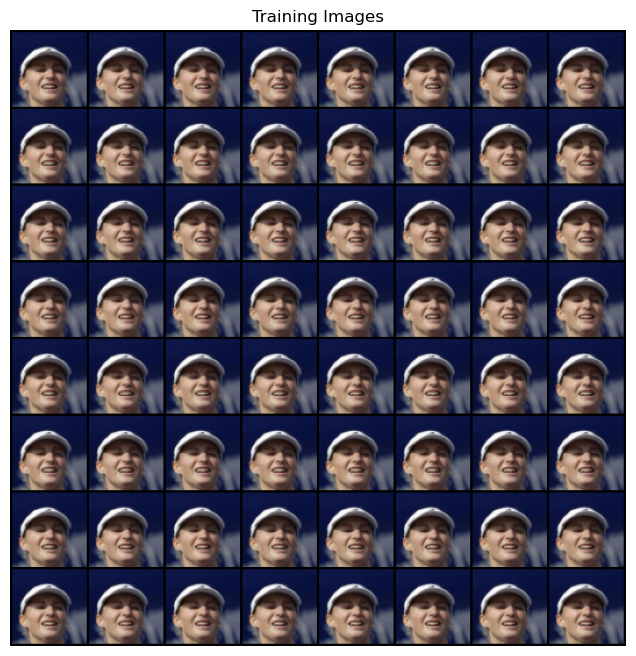

In [22]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))


In [23]:
gen_model = Generator(latent_dim_z, num_gen_features, num_channels).to(device)
gen_model

Generator(
  (main_model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [24]:
dis_model = Discriminator(num_dis_features, num_channels).to(device)
dis_model

Discriminator(
  (main_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [25]:
# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (num_gpu > 1):
#     gen_model = nn.DataParallel(gen_model, list(range(num_gpu)))
#     dis_model = nn.DataParallel(gen_model, list(range(num_gpu)))

In [26]:
# Initialize Loss Function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latent_dim_z, 1, 1, device=device)

In [27]:
real_label: float = 1.
fake_label: float = 0.

## Setup AdamW optimizers for both G and D

In [28]:

optimizer_dis = optim.AdamW(dis_model.parameters(), lr=learning_rate, betas=(beta_1, 0.999))
optimizer_gen = optim.AdamW(gen_model.parameters(), lr=learning_rate, betas=(beta_1, 0.999))

## Training Loop

In [29]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Starting Training Loop...')

for epoch in range(num_epochs):
    print(f'Epoch: ({epoch}/{num_epochs})')

    for idx, (input_data, _) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with all-real batch
        dis_model.zero_grad()

        input_data = input_data.to(device)
        b_size = input_data.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through Discriminator
        output = dis_model(input_data).view(-1)
        real_dis_loss = criterion(output, label)
        real_dis_loss.backward()
        D_x = output.mean().item()

        # Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim_z, 1, 1, device=device)

        # Generate fake image batch with Generator
        fake = gen_model(noise)
        label.fill_(fake_label)
        # Classify all-fake batch with D
        output = dis_model(fake.detach()).view(-1)
        # Calculate Discriminators loss on the all-fake batch
        fake_dis_loss = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with the previous gradients
        fake_dis_loss.backward()
        D_G_z1 = output.mean().item()
        # Compute error of Discriminator as sum over the fake and the real batches
        discriminator_loss = real_dis_loss + fake_dis_loss
        # Update Discriminator
        optimizer_dis.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen_model.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated the Discriminator, perform another forward pass of all-fake batch through D
        output = dis_model(fake).view(-1)
        # Calculate Generators loss based on this output
        generator_loss = criterion(output, label)
        # Calculate gradients for Generator
        generator_loss.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizer_gen.step()

        # Output training stats
        if idx % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{idx}/{len(dataloader)}]\tLoss_D: {discriminator_loss.item()}.4f\tLoss_G: {generator_loss.item()}.4f\tD(x): {D_x}.4f\tD(G(z)): {D_G_z1}.4f / {D_G_z2}.4f')

        # Save Losses for plotting later
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Epoch: (0/1)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()